In [23]:

#Pretrained best custom model

In [1]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from io import BytesIO
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

2023-09-05 08:18:58.106160: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 08:18:58.179970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 08:18:58.985870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def get_classes(dataset_dir):
    """
    Get the list of class names from the subdirectories of the dataset directory.

    Args:
        dataset_dir (str): Path to the dataset directory containing class subdirectories.

    Returns:
        list: List of class names.
    """
    classes = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]
    return classes

def analyze_dataset(dataset_dir, classes):
    
    image_shapes = set()
    images_per_class = {}

    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        images_per_class[class_name] = len(image_files)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            try:
                image = Image.open(image_path)
                image_shapes.add(image.size + (len(image.getbands()),))
            except Exception as e:
                print(f"Error processing image: {image_path}, {e}")

    print("Number of Images per Class:")
    for class_name, count in images_per_class.items():
        print(f"{class_name}: {count}")

    print("\nUnique Image Shapes:")
    for shape in image_shapes:
        print(shape)

In [4]:
def preprocess_image(image):
    # Resize the image to the target size
    image = tf.image.resize(image, target_size)

    # If the image has an alpha channel, drop it
    if image.shape[2] == 4:
        image = image[:, :, :3]
        
    return image

def create_data_generator(data_dir, target_size, batch_size, validation_split=0.2, augmentation=False, **kwargs):
    if augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            shear_range=0.2,
            zoom_range=0.2,
            rotation_range=30,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest',
            brightness_range=(0.85, 1.15),
            validation_split=validation_split,
            preprocessing_function=preprocess_image,
            **kwargs
        )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            validation_split=validation_split,
            preprocessing_function=preprocess_image,
            **kwargs
        )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
    )

    return train_generator, validation_generator


def display_random_images_from_generator(data_generator, classes, num_images=8):
    images, labels = next(data_generator)
    class_indices = {v: k for k, v in classes.items()}  # Reverse the class indices dictionary
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16/1.5, 8/1.5))
    
    for i in range(num_images):
        row = i // 4
        col = i % 4
        image = images[i]
        label = labels[i]
        class_index = label.argmax()
        class_name = class_indices[class_index]
    
        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title(class_name)
    
    plt.tight_layout()
    plt.show()

In [7]:
import sys

print(sys.path)


['/home/jovyan/workspace', '/opt/saturncloud/envs/saturn/lib/python39.zip', '/opt/saturncloud/envs/saturn/lib/python3.9', '/opt/saturncloud/envs/saturn/lib/python3.9/lib-dynload', '', '/opt/saturncloud/envs/saturn/lib/python3.9/site-packages']


In [8]:
dataset_dir = "/home/jovyan/workspace/dataset"
target_size = (256, 256)
classes = get_classes(dataset_dir)
print("Classes found in the dataset:", classes, "\n")
analyze_dataset(dataset_dir, classes)


Classes found in the dataset: ['Cloudy', 'Desert', '.ipynb_checkpoints', 'Water', 'Green'] 

Error processing image: /home/jovyan/workspace/dataset/Green/.ipynb_checkpoints, [Errno 21] Is a directory: '/home/jovyan/workspace/dataset/Green/.ipynb_checkpoints'
Number of Images per Class:
Cloudy: 1500
Desert: 1131
.ipynb_checkpoints: 0
Water: 1500
Green: 1501

Unique Image Shapes:
(256, 256, 4)
(64, 64, 3)
(256, 256, 3)


In [9]:
train_generator, validation_generator = create_data_generator(dataset_dir, target_size=target_size,
                                                             batch_size=32, validation_split=0.2, 
                                                              augmentation=True)

Found 4506 images belonging to 5 classes.
Found 1126 images belonging to 5 classes.


2023-09-05 09:24:17.447229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 09:24:17.661293: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


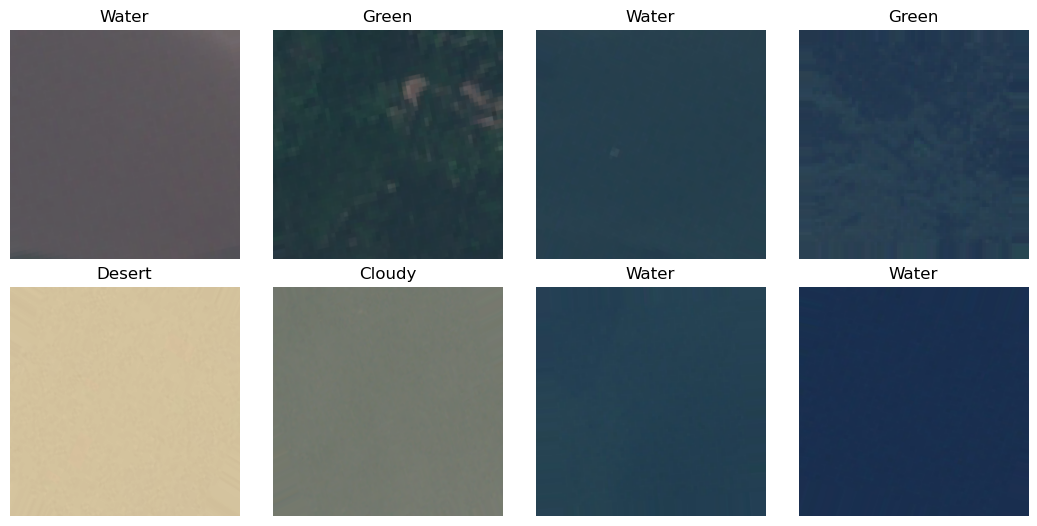

In [10]:
classes = train_generator.class_indices
display_random_images_from_generator(train_generator, classes, num_images=8)

In [13]:
import tensorflow as tf

# Define the distribution strategy (e.g., MirroredStrategy for multi-GPU)
strategy = tf.distribute.MirroredStrategy()

# Now you can access the number of replicas using strategy.num_replicas_in_sync
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 20

# Rest of your code with the learning rate schedule and callbacks


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Learning rate schedule: 1e-05 to 0.0001 to 1e-05


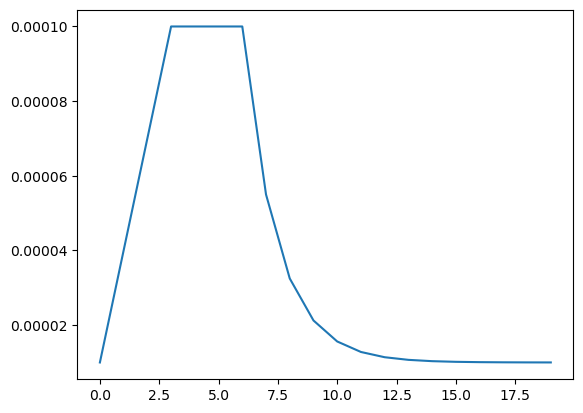

In [14]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
EPOCHS = 20

# Learning rate schedule
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [15]:
#Model Training

In [20]:
NUM_TRAINING_IMAGES = train_generator.n
NUM_VALIDATION_IMAGES = validation_generator.n
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE)  # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

def train_model(train_generator, validation_generator, target_size, num_classes, model_name,
                epochs, batch_size, patience=3):
    
    model = create_model(target_size, num_classes)
    optimizer = Adam()
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_name + '.h5', save_best_only=True, save_weights_only=True)

    
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH, 
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        callbacks=[lr_callback,early_stopping, model_checkpoint]
    )

    # Evaluate the model on the validation set
    evaluation = model.evaluate(validation_generator)

    # Save the model
    model.save(model_name + '.h5')

    # Print message when early stopping is triggered
    if early_stopping.stopped_epoch > 0:
        print('Early stopping triggered at epoch', early_stopping.stopped_epoch + 1)

    return history, evaluation


def create_model(target_size, num_classes):
     with strategy.scope():
        model = models.Sequential()

        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=target_size + (3,)))
        model.add(layers.MaxPooling2D((2, 2)))

        model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.15))

        model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.30))

        model.add(layers.Flatten())

        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.50))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model

    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])    
    
def display_curves(history):
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)    
    

# Model Evaluation
def evaluate_model(saved_model_path, validation_generator):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(saved_model_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)

    # Perform thorough evaluation
    y_true = validation_generator.classes
    y_pred = loaded_model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate overall metrics
    accuracy = metrics.accuracy_score(y_true, y_pred_classes)
    precision = metrics.precision_score(y_true, y_pred_classes, average='weighted')
    recall = metrics.recall_score(y_true, y_pred_classes, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred_classes, average='weighted')

    print('Overall Metrics:')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1_score)

    # Define the target class names in the same order as they appear in your dataset
    target_names = ['Cloudy', 'Desert', 'Green', 'Water']

    # Calculate metrics per class
    class_metrics = metrics.classification_report(y_true, y_pred_classes, target_names=target_names)
    print('\nMetrics per Class:')
    print(class_metrics)

Dataset: 4506 training images, 1126 validation images


In [17]:
# Rest of the code remains the same
num_classes = train_generator.num_classes
model_name = 'best_custom_model'
epochs = 20
batch_size = 32


history, evaluation = train_model(
    train_generator,
    validation_generator,
    target_size=target_size,
    num_classes=num_classes,
    model_name=model_name,
    epochs=epochs,
    batch_size=batch_size,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

2023-09-05 09:28:01.894804: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\017TensorDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-09-05 09:28:01.955155: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the datase

140/140 [==============================] - ETA: 0s - loss: 1.1817 - accuracy: 0.4426

2023-09-05 09:29:54.996578: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020TensorDataset:19"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}

2023-09-05 09:29:55.043930: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the datas

140/140 [==============================] - 132s 935ms/step - loss: 1.1817 - accuracy: 0.4426 - val_loss: 0.9296 - val_accuracy: 0.6465 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/20
140/140 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.6658

2023-09-05 09:32:03.882095: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 129s 919ms/step - loss: 0.6456 - accuracy: 0.6658 - val_loss: 0.6325 - val_accuracy: 0.6634 - lr: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 7.000000000000001e-05.
Epoch 3/20
140/140 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.7231

2023-09-05 09:34:14.929310: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 131s 933ms/step - loss: 0.5286 - accuracy: 0.7231 - val_loss: 0.5039 - val_accuracy: 0.8259 - lr: 7.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/20
140/140 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.7906

2023-09-05 09:36:24.342066: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 129s 924ms/step - loss: 0.4685 - accuracy: 0.7906 - val_loss: 0.4934 - val_accuracy: 0.7913 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/20
140/140 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8368

2023-09-05 09:38:34.377791: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 928ms/step - loss: 0.3960 - accuracy: 0.8368 - val_loss: 0.4304 - val_accuracy: 0.8321 - lr: 1.0000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/20
140/140 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.8525

2023-09-05 09:40:44.032689: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 925ms/step - loss: 0.3649 - accuracy: 0.8525 - val_loss: 0.4068 - val_accuracy: 0.8526 - lr: 1.0000e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0001.
Epoch 7/20
140/140 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8587

2023-09-05 09:42:54.806152: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 931ms/step - loss: 0.3521 - accuracy: 0.8587 - val_loss: 0.4415 - val_accuracy: 0.8330 - lr: 1.0000e-04

Epoch 8: LearningRateScheduler setting learning rate to 5.5e-05.
Epoch 8/20
140/140 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8684

2023-09-05 09:45:05.495294: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 131s 934ms/step - loss: 0.3282 - accuracy: 0.8684 - val_loss: 0.4326 - val_accuracy: 0.8410 - lr: 5.5000e-05

Epoch 9: LearningRateScheduler setting learning rate to 3.2500000000000004e-05.
Epoch 9/20
140/140 [==============================] - ETA: 0s - loss: 0.3110 - accuracy: 0.8786

2023-09-05 09:47:14.454628: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 129s 920ms/step - loss: 0.3110 - accuracy: 0.8786 - val_loss: 0.3941 - val_accuracy: 0.8570 - lr: 3.2500e-05

Epoch 10: LearningRateScheduler setting learning rate to 2.125e-05.
Epoch 10/20
140/140 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.8755

2023-09-05 09:49:24.531948: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 927ms/step - loss: 0.3082 - accuracy: 0.8755 - val_loss: 0.3892 - val_accuracy: 0.8552 - lr: 2.1250e-05

Epoch 11: LearningRateScheduler setting learning rate to 1.5625e-05.
Epoch 11/20
140/140 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8838

2023-09-05 09:51:36.551328: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 132s 941ms/step - loss: 0.3019 - accuracy: 0.8838 - val_loss: 0.3840 - val_accuracy: 0.8579 - lr: 1.5625e-05

Epoch 12: LearningRateScheduler setting learning rate to 1.2812500000000001e-05.
Epoch 12/20
140/140 [==============================] - ETA: 0s - loss: 0.3017 - accuracy: 0.8815

2023-09-05 09:53:46.425999: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 927ms/step - loss: 0.3017 - accuracy: 0.8815 - val_loss: 0.3805 - val_accuracy: 0.8597 - lr: 1.2813e-05

Epoch 13: LearningRateScheduler setting learning rate to 1.1406250000000001e-05.
Epoch 13/20
140/140 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.8882

2023-09-05 09:55:56.927242: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 928ms/step - loss: 0.2875 - accuracy: 0.8882 - val_loss: 0.4115 - val_accuracy: 0.8499 - lr: 1.1406e-05

Epoch 14: LearningRateScheduler setting learning rate to 1.0703125000000001e-05.
Epoch 14/20
140/140 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.8858

2023-09-05 09:58:06.466893: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 925ms/step - loss: 0.2921 - accuracy: 0.8858 - val_loss: 0.3635 - val_accuracy: 0.8668 - lr: 1.0703e-05

Epoch 15: LearningRateScheduler setting learning rate to 1.03515625e-05.
Epoch 15/20
140/140 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.8905

2023-09-05 10:00:15.908556: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 129s 922ms/step - loss: 0.2957 - accuracy: 0.8905 - val_loss: 0.3735 - val_accuracy: 0.8615 - lr: 1.0352e-05

Epoch 16: LearningRateScheduler setting learning rate to 1.017578125e-05.
Epoch 16/20
140/140 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8867

2023-09-05 10:02:25.821810: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 130s 926ms/step - loss: 0.2881 - accuracy: 0.8867 - val_loss: 0.3734 - val_accuracy: 0.8623 - lr: 1.0176e-05

Epoch 17: LearningRateScheduler setting learning rate to 1.0087890625e-05.
Epoch 17/20
140/140 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8856

2023-09-05 10:04:37.105520: W tensorflow/core/framework/dataset.cc:956] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


140/140 [==============================] - 131s 937ms/step - loss: 0.2900 - accuracy: 0.8856 - val_loss: 0.3721 - val_accuracy: 0.8641 - lr: 1.0088e-05


2023-09-05 10:04:56.896596: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:358"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



36/36 [==============================] - 19s 525ms/step - loss: 0.3691 - accuracy: 0.8668


/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Early stopping triggered at epoch 17


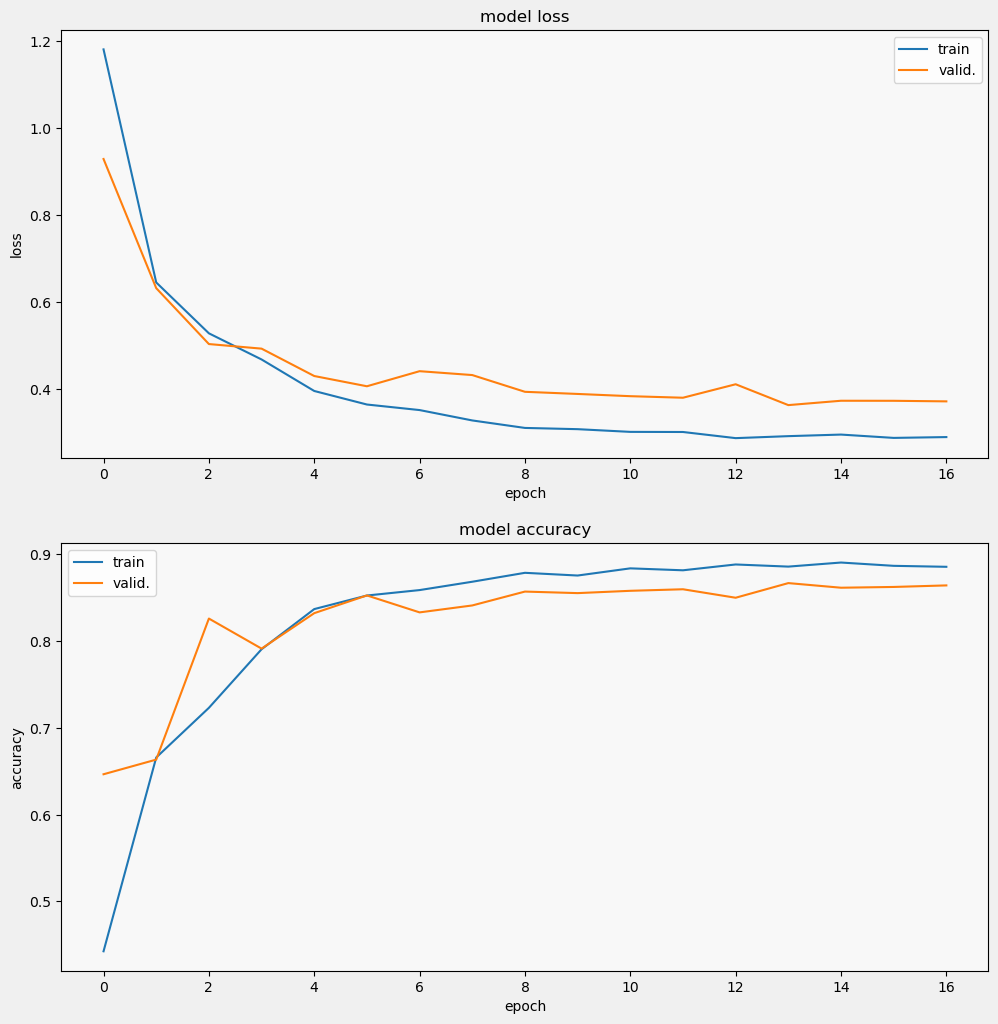

In [18]:
display_curves(history)

In [21]:
saved_model_path = 'best_custom_model.h5'

evaluate_model(saved_model_path, validation_generator)

36/36 [==============================] - 19s 529ms/step - loss: 0.3593 - accuracy: 0.8694
Test Loss: 0.3592885136604309
Test Accuracy: 0.8694493770599365
36/36 [==============================] - 19s 524ms/step
Overall Metrics:
Accuracy: 0.8579040852575488
Precision: 0.8781370781496556
Recall: 0.8579040852575488
F1-Score: 0.854439346934777

Metrics per Class:
              precision    recall  f1-score   support

      Cloudy       0.97      0.87      0.92       300
      Desert       0.86      1.00      0.92       226
       Green       0.74      0.96      0.83       300
       Water       0.94      0.64      0.76       300

    accuracy                           0.86      1126
   macro avg       0.88      0.87      0.86      1126
weighted avg       0.88      0.86      0.85      1126



In [22]:
#Prediction on new data

In [24]:
def predict_images_from_urls(model, classes, image_urls, target_size):
    num_images = len(image_urls)
    num_rows = (num_images + 3) // 4

    fig, axs = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 6))

    for i, image_url in enumerate(image_urls):
        row = i // 4
        col = i % 4

        # Download the image from the URL
        response = requests.get(image_url)

        if response.status_code == 200:
            try:
                image = Image.open(BytesIO(response.content))
                image = image.convert("RGB")  # Convert to RGB format

                # Resize the image
                image = image.resize(target_size)

                # Preprocess the image
                image_array = np.array(image) / 255.0
                image_array = np.expand_dims(image_array, axis=0)

                # Make the prediction
                prediction = model.predict(image_array)
                predicted_class_index = np.argmax(prediction)

                # Create a reverse dictionary of classes
                reverse_classes = {v: k for k, v in classes.items()}

                # Get the predicted class label
                predicted_class = reverse_classes[predicted_class_index]

                # Display the image and predicted class
                axs[row, col].imshow(image)
                axs[row, col].axis('off')
                axs[row, col].set_title(f"Predicted Class: {predicted_class}")
            except (UnidentifiedImageError, ImageDecompressionBombError) as e:
                print(f"Error processing image: {image_url}\n{e}")

    # Remove any empty subplots
    for i in range(num_images, num_rows * 4):
        row = i // 4
        col = i % 4
        fig.delaxes(axs[row, col])

    fig.tight_layout()
    plt.show()

1/1 [==============================] - 0s 26ms/step


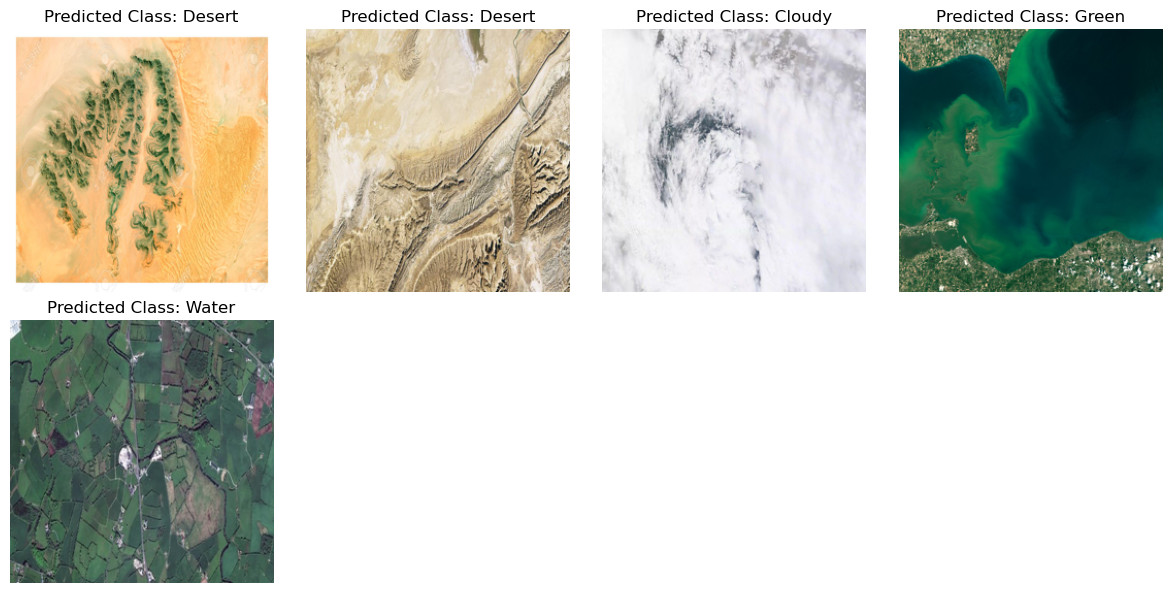

In [29]:
image_urls = [
    'https://previews.123rf.com/images/vampy1/vampy12007/vampy1200700021/151785736-satellite-view-of-namibia-desert-landscape-and-mountains-nature-and-aerial-view-global-warming.jpg',
    'https://thumbs.dreamstime.com/b/desert-land-satellite-photo-topography-aerial-top-view-earth-surface-as-abstract-background-nature-pattern-southern-sand-229623767.jpg',
    'https://miro.medium.com/v2/resize:fit:1000/0*59yUF7X3jRrcrUnu.jpg',
    'https://media.rff.org/images/resized_erie_oli_2015209_lrg_40.2e16d0ba.fill-1270x1120.jpg',
    'https://img.rasset.ie/0014aa0a-500.jpg',
    
]


# Load the saved custom model and classes
loaded_model = tf.keras.models.load_model(saved_model_path)

# Predict and display the images from the URLs
predict_images_from_urls(loaded_model, classes, image_urls, target_size)

In [30]:
#InceptionV3

In [31]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images
    numpy_labels = labels.astype(int)
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels



def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[int(label)], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[int(label)], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[int(correct_label)] if not correct else ''), correct


def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label[0]]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label[0])
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [32]:
def create_model(target_size, num_classes,verbose=False):
    # Pre-trained model
    pretrained_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(256, 256, 3)
    )
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda data: tf.keras.applications.inception_v3.preprocess_input(tf.cast(data, tf.float32))),
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    # Learning rate scheduling
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    # Optimizer and compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    if verbose:
        model.summary()
    return model


def train_new_model(train_generator, validation_generator, target_size, num_classes, model_name,
                    batch_size,verbose):
    model = create_model(target_size, num_classes,verbose=False)
    

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_name + '.h5', save_best_only=True, save_weights_only=True)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        callbacks=[lr_callback, early_stopping, model_checkpoint]
    )

    # Evaluate the model on the validation set
    evaluation = model.evaluate(validation_generator)

    # Save the model
    model.save(model_name + '.h5')

    # Print message when early stopping is triggered
    if early_stopping.stopped_epoch > 0:
        print('Early stopping triggered at epoch', early_stopping.stopped_epoch + 1)

    return history, evaluation

def display_curves(history):
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
    display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)

In [33]:
num_classes = train_generator.num_classes
model_name = 'custom_model'
epochs = 15
batch_size = 32


history, evaluation = train_new_model(
    train_generator,
    validation_generator,
    target_size=target_size,
    num_classes=num_classes,
    model_name=model_name,
    batch_size=batch_size,
    verbose=True
)

87910968/87910968 [==============================] - 1s 0us/step

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
140/140 [==============================] - 227s 2s/step - loss: 1.3504 - accuracy: 0.3549 - val_loss: 1.2720 - val_accuracy: 0.6652 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/20
140/140 [==============================] - 221s 2s/step - loss: 1.2252 - accuracy: 0.4991 - val_loss: 1.1824 - val_accuracy: 0.5240 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 7.000000000000001e-05.
Epoch 3/20
140/140 [==============================] - 220s 2s/step - loss: 1.1316 - accuracy: 0.5666 - val_loss: 1.0861 - val_accuracy: 0.6838 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/20
140/140 [==============================] - 220s 2s/step - loss: 1.0617 - accuracy: 0.6185 - val_loss: 1.0676 - val_accuracy: 0.4467 - lr: 0.0010

Epoch 5: LearningRateScheduler settin

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Early stopping triggered at epoch 15


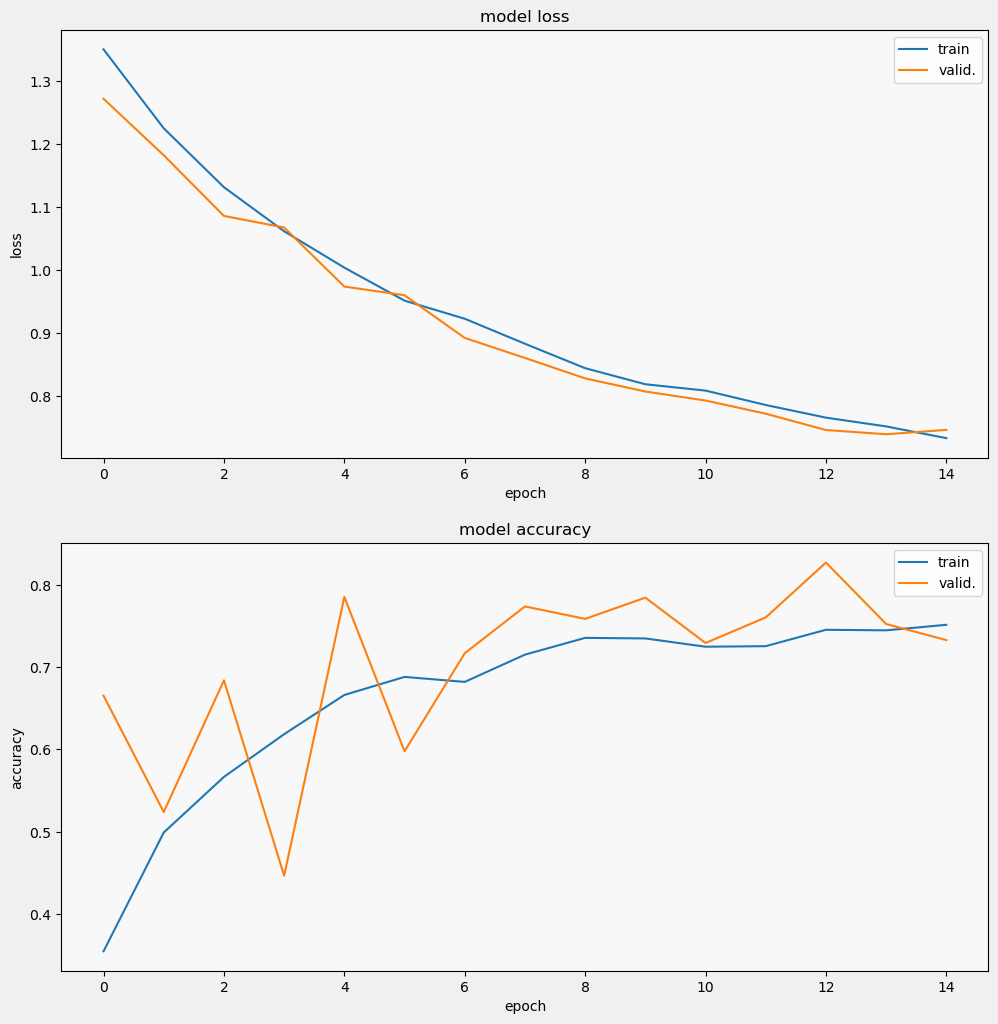

In [34]:
display_curves(history)

In [35]:
model_path = 'custom_model.h5'

evaluate_model(model_path, validation_generator)

36/36 [==============================] - 46s 1s/step - loss: 0.7334 - accuracy: 0.7611
Test Loss: 0.7333676218986511
Test Accuracy: 0.761101245880127
36/36 [==============================] - 46s 1s/step
Overall Metrics:
Accuracy: 0.7735346358792184
Precision: 0.8092479164469374
Recall: 0.7735346358792184
F1-Score: 0.7566510749727178

Metrics per Class:
              precision    recall  f1-score   support

      Cloudy       0.61      0.83      0.70       300
      Desert       0.93      0.33      0.48       226
       Green       0.92      0.87      0.89       300
       Water       0.82      0.95      0.88       300

    accuracy                           0.77      1126
   macro avg       0.82      0.75      0.74      1126
weighted avg       0.81      0.77      0.76      1126



In [ ]:
#ResNet34

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def residual_block(x, filters, stride=1):
    shortcut = x
    
    # First convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), strides=(stride, stride), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection
    if stride > 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=(stride, stride), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet34(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    
    # Initial convolution layer
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # MaxPooling layer
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual blocks
    num_blocks_list = [3, 4, 6, 3]
    filters_list = [64, 128, 256, 512]
    
    for stage, num_blocks, filters in zip(range(4), num_blocks_list, filters_list):
        for block in range(num_blocks):
            stride = 1 if stage == 0 and block == 0 else 2
            x = residual_block(x, filters, stride)
    
    # Global AveragePooling layer
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x, name='ResNet34')
    return model

# Define input shape and number of classes
input_shape = (256, 256, 3)  # Adjust this according to your dataset
num_classes = train_generator.num_classes  # Assuming you have this variable defined

# Create the ResNet-34 model
model = ResNet34(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()




Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_193 (Conv2D)         (None, 128, 128, 64)         9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_190 (B  (None, 128, 128, 64)         256       ['conv2d_193[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_160 (Activation  (None, 128, 128, 64)         0         ['batch_normalization_1

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)  # Adjust patience as needed
model_checkpoint = ModelCheckpoint(model_name + '.h5', save_best_only=True, save_weights_only=True)

# Training the ResNet-34 model
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)

# Print message when early stopping is triggered
if early_stopping.stopped_epoch > 0:
    print('Early stopping triggered at epoch', early_stopping.stopped_epoch + 1)



Epoch 1/15
140/140 [==============================] - 183s 1s/step - loss: 0.7408 - accuracy: 0.7152 - val_loss: 1.4557 - val_accuracy: 0.2664
Epoch 2/15
140/140 [==============================] - 168s 1s/step - loss: 0.4684 - accuracy: 0.8134 - val_loss: 1.0409 - val_accuracy: 0.4538
Epoch 3/15
140/140 [==============================] - 168s 1s/step - loss: 0.4699 - accuracy: 0.8176 - val_loss: 0.6714 - val_accuracy: 0.7140
Epoch 4/15
140/140 [==============================] - 167s 1s/step - loss: 0.4172 - accuracy: 0.8366 - val_loss: 0.5786 - val_accuracy: 0.6670
Epoch 5/15
140/140 [==============================] - 168s 1s/step - loss: 0.4232 - accuracy: 0.8279 - val_loss: 0.6951 - val_accuracy: 0.7123
Epoch 6/15
140/140 [==============================] - 168s 1s/step - loss: 0.3961 - accuracy: 0.8400 - val_loss: 1.1677 - val_accuracy: 0.5604
Epoch 7/15
140/140 [==============================] - 168s 1s/step - loss: 0.4042 - accuracy: 0.8388 - val_loss: 1.4214 - val_accuracy: 0.5782

In [55]:
import matplotlib.pyplot as plt

def display_training_curves(history, metric, title, subplot):
    plt.subplot(subplot)
    plt.plot(history[metric], label='Training ' + metric)
    plt.plot(history['val_' + metric], label='Validation ' + metric)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()

def display_curves(history):
    plt.figure(figsize=(12, 5))

    display_training_curves(history, 'loss', 'Loss', 121)
    display_training_curves(history, 'accuracy', 'Accuracy', 122)

    plt.show()


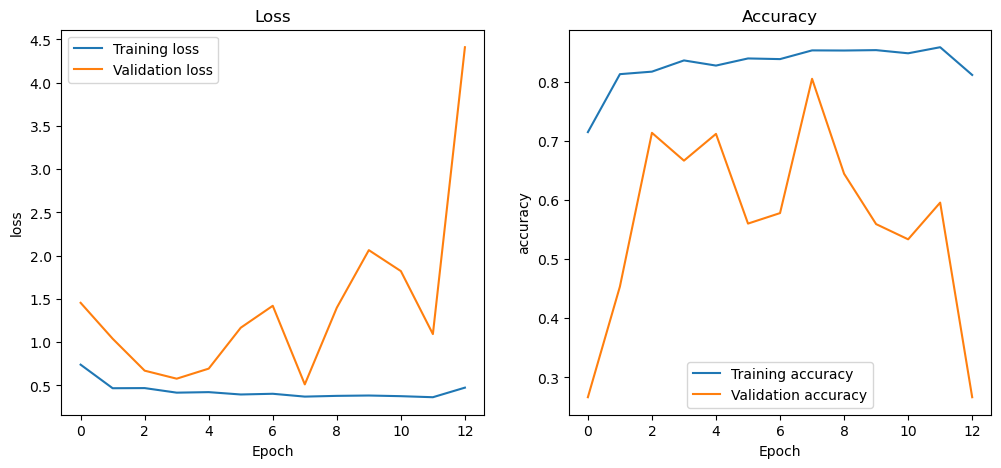

In [56]:
# After training your model and storing the history object
display_curves(history.history)


In [58]:
model.save(model_name + '.h5')

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
model_path = 'resnet34_model.h5'

evaluate_model(model_path, validation_generator)

36/36 [==============================] - 23s 605ms/step - loss: 0.5167 - accuracy: 0.8020
Test Loss: 0.5167482495307922
Test Accuracy: 0.8019537925720215
36/36 [==============================] - 23s 613ms/step
Overall Metrics:
Accuracy: 0.7984014209591475
Precision: 0.8075806758351021
Recall: 0.7984014209591475
F1-Score: 0.7924599462158914

Metrics per Class:
              precision    recall  f1-score   support

      Cloudy       0.78      0.79      0.79       300
      Desert       0.78      1.00      0.88       226
       Green       0.77      0.85      0.81       300
       Water       0.89      0.60      0.72       300

    accuracy                           0.80      1126
   macro avg       0.81      0.81      0.80      1126
weighted avg       0.81      0.80      0.79      1126



In [60]:
#Transfer Learning Approach

In [68]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
target_size = (256, 256)
num_classes = 4
batch_size = 32
EPOCHS = 20  # Adjust as needed
STEPS_PER_EPOCH = len(train_generator) // batch_size
VALIDATION_STEPS = len(validation_generator) // batch_size
model_name = 'my_transfer_learning_model'

def create_model(target_size, num_classes, verbose=False):
    # Pre-trained model
    pretrained_model = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(target_size[0], target_size[1], 3)
    )
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        Lambda(lambda data: tf.keras.applications.inception_v3.preprocess_input(tf.cast(data, tf.float32))),
        pretrained_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    # Learning rate scheduling
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    # Optimizer and compile the model
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Build the model
    model.build((None, target_size[0], target_size[1], 3))
    
    if verbose:
        model.summary()
    
    return model

def train_new_model(train_generator, validation_generator, target_size, num_classes, model_name,
                    batch_size, verbose=True):
    model = create_model(target_size, num_classes, verbose=verbose)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_name + '.h5', save_best_only=True, save_weights_only=True)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        batch_size=batch_size,
        validation_data=validation_generator,
        validation_steps=VALIDATION_STEPS,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model on the validation set
    evaluation = model.evaluate(validation_generator)

    # Save the model
    model.save(model_name + '.h5')

    # Print message when early stopping is triggered
    if early_stopping.stopped_epoch > 0:
        print('Early stopping triggered at epoch', early_stopping.stopped_epoch + 1)

    return history, evaluation

# Assuming you have train_generator and validation_generator created using ImageDataGenerator.
history, evaluation = train_new_model(train_generator, validation_generator, target_size, num_classes, model_name, batch_size)




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21810980 (83.20 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 21802784 (83.17 MB)
__________

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/opt/saturncloud/envs/saturn/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/saturncloud/envs/saturn/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4483/3207660966.py", line 87, in <module>
      history, evaluation = train_new_model(train_generator, validation_generator, target_size, num_classes, model_name, batch_size)
    File "/tmp/ipykernel_4483/3207660966.py", line 64, in train_new_model
      history = model.fit(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,4] labels_size=[32,5]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_2330215]

IndentationError: expected an indented block (1003419374.py, line 24)